In [1]:
import glob
import numpy as np
import pandas as pd
import networkx as nx
from itertools import islice
import matplotlib.pyplot as plt

In [2]:
class TrafficAssignment:
    def __init__(self, file_path, od_path, node_attr, instance_name="sample", algorithm_name ="FW", eps=1e-3):
        G = self.create_network(file_path, node_attr)
        self.graph=G
        od, od_demand = self.get_od(od_path=od_path, od_mask=None)
        self.od=od
        self.od_demand=od_demand
        self.beta = self.get_edge_attributes('beta')
        self.alpha = self.get_edge_attributes('alpha')
        self.fftt = self.get_edge_attributes("travel_time")
        self.capacity = self.get_edge_attributes("capacity")
        self.eps=eps
        self.edges = list(self.graph.edges())
        self.nodes = list(self.graph.nodes())
        self.num_edges = len(self.edges)
        self.num_nodes = len(self.nodes)
        self.link_time = np.zeros(self.num_edges)
        self.link_flow = np.zeros(self.num_edges)
        self.iteration = 0
        self.converged = False
        self.old_gap=1e9
        self.UE_sol = 1e6*np.ones(self.num_edges)
        self.algorithm_name = algorithm_name
        if self.algorithm_name in ["FW","MSA"]:
            self.pqs = None
            self.link_flows = None
        elif self.algorithm_name == "PBA":
            self.pqs = [[] for _ in range(len(self.od))] 
            self.list_flows = [[] for _ in range(len(self.od))]
        else:
            raise ValueError(f"Alogrithm name {self.algorithm_name} not support.")
        if instance_name == 'SiouxFalls':
            self.UE_sol_LB = 4231335.28710744
        elif instance_name == 'sample':
            self.UE_sol_LB = 1719653.819467463
        else:
            raise ValueError("instance name not found")
    
    def get_od(self, od_path, od_mask=None):
        od = pd.read_csv(od_path)
        ods = od[['O', 'D']].values.tolist()
        ods_demand = od['Ton'].values.tolist()
        return ods, ods_demand
    
    def get_edge_attributes(self, attributes):
        '''
        get edge attributes: capacity, beta, alpha, travel_time, traffic_flow
        '''
        vals = nx.get_edge_attributes(self.graph,attributes).values()
        return np.array(list(vals))
    
    def step_fw(self, metric = "relative_gap",search_method = "bisection"):
        '''
        one step of traffic assignment
        metric = AEC or relative gap
        '''
        if self.iteration==0:
            init_shortest_path, init_shortest_path_cost=self.get_shortest_path()
            self.link_flow=self.map_path_to_link_flow(init_shortest_path)
        # record the current best link flow
        old_link_flow = self.link_flow
        self.save_UE_cost_function()

        # update travel time
        self.update_travel_time()

        # get the shortest path based on the new travel time
        shortest_path, shortest_path_cost = self.get_shortest_path()
        if metric == "relative_gap":
            gap = np.sum(self.UE_sol)/self.UE_sol_LB-1
            if gap < self.eps:
                self.converged = True
        else:
            raise ValueError(f"metric {metric} not supported.")
        # map the shortest path to link flow
        new_link_flow = self.map_path_to_link_flow(shortest_path)

        if search_method == "bisection":
            lbd, n_iter = self.bisection_search(old_link_flow, new_link_flow) # optimal lambda
            print('Iteration={},lambda={},bisection iterations={}'.format(self.iteration,lbd,n_iter))
            self.link_flow = self.convex_combination(old_link_flow, new_link_flow, lbd)
        elif search_method == "exact":
            tau = self.fsolve_search(old_link_flow, new_link_flow) # optimal lambda
            self.link_flow=old_link_flow+tau*(new_link_flow-old_link_flow)
            n_iter=-1 # a placeholder, not available for fsolve
        else:
            raise ValueError(f"search method {search_method} not supported.")

        self.update_link_flow() # self.link_flow
        self.update_travel_time()

        self.save_shortest_path(shortest_path)

        # update iteration
        self.iteration += 1
        return gap
    
    
    def get_shortest_path(self):
        list_sp = [nx.dijkstra_path(self.graph, self.od[i][0], self.od[i][1], weight='travel_time') for i in range(len(self.od))]
        list_sp_cost = [np.sum([self.graph[i][j]["travel_time"] for (i,j) in zip(sp,sp[1:])]) for sp in list_sp]
        return list_sp, list_sp_cost

    def map_path_to_link_flow(self, path):
        '''
        map the shortest path to link flow
        '''
        link_flow = np.zeros(self.num_edges)

        for pid,p in enumerate(path):
            for i in range(len(p) - 1):
                link_flow[self.edges.index((p[i], p[i + 1]))] += self.od_demand[pid]
        return link_flow
    
    def save_UE_cost_function(self):
        '''
        save the UE cost function to the graph
        '''
        self.UE_sol = self.fftt*self.link_flow + self.capacity/(self.alpha+1)*self.fftt*self.beta*(self.link_flow/self.capacity)**(self.alpha+1)
    
    def update_travel_time(self):
        # update link travel time
        self.link_time = self.fftt*(1+self.beta*(self.link_flow/self.capacity)**self.alpha)
        # then update the link_time to each edge attribute
        for e,tt in zip(self.edges,self.link_time):
            self.graph[e[0]][e[1]]["travel_time"]=tt #update link travel time in the graph

    def update_link_flow(self):
        '''
        updated link flow (according to the shortest path)
        theta: step size (default: 1, bisection method)
        '''
        # update the link_flow to each edge attribute
        for e,f in zip(self.edges,self.link_flow):
            self.graph[e[0]][e[1]]["travel_flow"]=f

    def save_shortest_path(self,shortest_path):
        '''
        save the shortest path to the graph
        '''
        self.graph._shortest_path = shortest_path

    def get_graph(self):
        return self.graph


    def bisection_search(self,x1,x2,eps=1e-8):
        '''
        bisection search         
        for the optimal step size: lambda
        the goal is to minimize the gap
        old link flow --x--x---o------ new link flow
        '''
        l = 0
        l_ = 1
        n_iter = 0  # iteration
        while abs(l_ - l) > eps:  # stopping criteria
            c = self.compute_gradient(x1, x2, (l + l_) / 2)
            if c > 0:
                l_ = l + (l_ - l) / 2
            else:
                l = l + (l_ - l) / 2
            n_iter += 1
        return (l + l_) / 2, n_iter


    def fsolve_search(self,x1,x2,eps=1e-8):
        '''
        the goal is to minimize the gap
        '''
        def formula():
            '''
            x1: the current link flow assignment
            x2: the shortest path flow assignment
            lbd: lambda ratio
            '''
            # flow = (1 - lbd) * x1 + lbd * x2
            d=x2-x1
            link_cost = (self.fftt * (1 + self.beta * (x1 / self.capacity) ** self.alpha))
            hessian=np.diag(self.fftt*self.beta*self.alpha/self.capacity*(x1/self.capacity)**(self.alpha-1))

            tau= -link_cost.T@d/(d.T@hessian@d)

            return tau

        tau = formula()
        return tau

    def compute_gradient(self,x1,x2,lbd):
        '''
        x1: the current link flow assignment
        x2: the shortest path flow assignment
        lbd: lambda ratio
        '''
        flow=(1-lbd)*x1+lbd*x2
        link_cost=(self.fftt*(1+self.beta*(flow/self.capacity)**self.alpha))@(x2-x1)
        return link_cost

    @staticmethod
    def create_network(filepath,node_attr_path):
        '''
        Create a network from a csv file
        '''
        net = pd.read_csv(filepath)
        node_attr = pd.read_csv(node_attr_path)
        G = nx.DiGraph()
        for _, row in net.iterrows():  # iterate over all rows
            edge_id, fn, tn, tt_, capacity_, beta_, alpha_ = row  # unpack your attributes
            G.add_edge(fn, tn, edge_index = edge_id, travel_time=tt_, travel_flow=0, capacity=capacity_, beta=beta_, alpha=alpha_)
        # add node attributes
        for _, row in node_attr.iterrows():
            node, x, y = row
            G.add_node(node, x=x, y=y)

        return G
    
    @staticmethod
    def convex_combination(x, y, theta):
        return (1-theta)*x + theta*y



In [3]:
# read data
instance_name = "SiouxFalls" # "sample" # 
file_path = f'network_data/{instance_name}/network_net.csv'
node_attr = f'network_data/{instance_name}/network_node.csv'

N_iter = 500 # number of iterations
eps = 1e-8 # tolerance

# then we run the FW algorithm
algorithm_name = "FW" # Frank-Wolfe

with open(f'results/{instance_name}/results_{algorithm_name}.csv', 'w') as f:
    for od_path in glob.glob(f"network_data/{instance_name}/network_od*.csv"):

        model = TrafficAssignment(file_path, od_path, node_attr, instance_name, algorithm_name, eps) # set up the model

        # record the relative gap and the number of iterations
        gaps_FW=[]
        n_iters_FW=[]

        while (not model.converged) and model.iteration<N_iter:
            gap = model.step_fw(metric="relative_gap")
            gaps_FW.append(gap)
            n_iters_FW.append(model.iteration)
            if model.iteration % 100 == 0:
                print('iteration: {}, gap: {}'.format(model.iteration, gap))
            # record iteration and solution
            f.write(f"{model.iteration},{gap},{np.sum(model.UE_sol)}\n")

        break # only run one OD pair    

Iteration=0,lambda=0.363692756742239,bisection iterations=27
Iteration=1,lambda=0.22441742941737175,bisection iterations=27
Iteration=2,lambda=0.17606843635439873,bisection iterations=27
Iteration=3,lambda=0.38188617303967476,bisection iterations=27
Iteration=4,lambda=0.15574195608496666,bisection iterations=27
Iteration=5,lambda=0.22928406670689583,bisection iterations=27
Iteration=6,lambda=0.20216112956404686,bisection iterations=27
Iteration=7,lambda=0.15194037184119225,bisection iterations=27
Iteration=8,lambda=0.2220078893005848,bisection iterations=27
Iteration=9,lambda=0.14090819284319878,bisection iterations=27
Iteration=10,lambda=0.2905801571905613,bisection iterations=27
Iteration=11,lambda=0.1163347028195858,bisection iterations=27
Iteration=12,lambda=0.26795143261551857,bisection iterations=27
Iteration=13,lambda=0.07517190650105476,bisection iterations=27
Iteration=14,lambda=0.1367039941251278,bisection iterations=27
Iteration=15,lambda=0.07901005819439888,bisection iterat

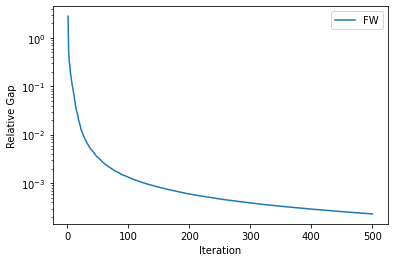

In [5]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(n_iters_FW,gaps_FW,label='FW')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Gap')
ax.legend()

['4526.74', '8092.20', '4494.76', '5997.07', '8124.18', '14050.90', '9999.07', '5965.08', '8798.29', '12528.06', '14032.47', '18049.65', '5321.29', '10049.48', '8367.12', '12413.05', '18032.02', '8801.76', '15803.66', '5220.49', '17724.72', '8410.28', '9819.68', '15789.51', '6879.43', '21822.98', '12492.60', '12106.69', '6830.51', '8402.14', '12044.56', '15867.74', '15805.61', '15304.74', '19026.38', '8379.89', '11052.91', '11667.42', '15359.39', '21757.75', '17604.10', '23195.37', '11071.86', '8100.90', '23125.90', '9036.22', '19115.41', '18378.70', '8103.47', '11680.87', '9938.65', '9782.65', '9087.61', '8382.67', '12320.30', '11109.40', '11116.66', '10298.31', '7904.14', '8397.03', '9659.07', '7863.33', '19080.41', '9954.67', '8697.85', '18392.84', '7004.13', '8608.97', '9632.63', '19009.60', '8678.87', '6247.73', '7000.68', '6308.52', '8600.12', '10246.37']


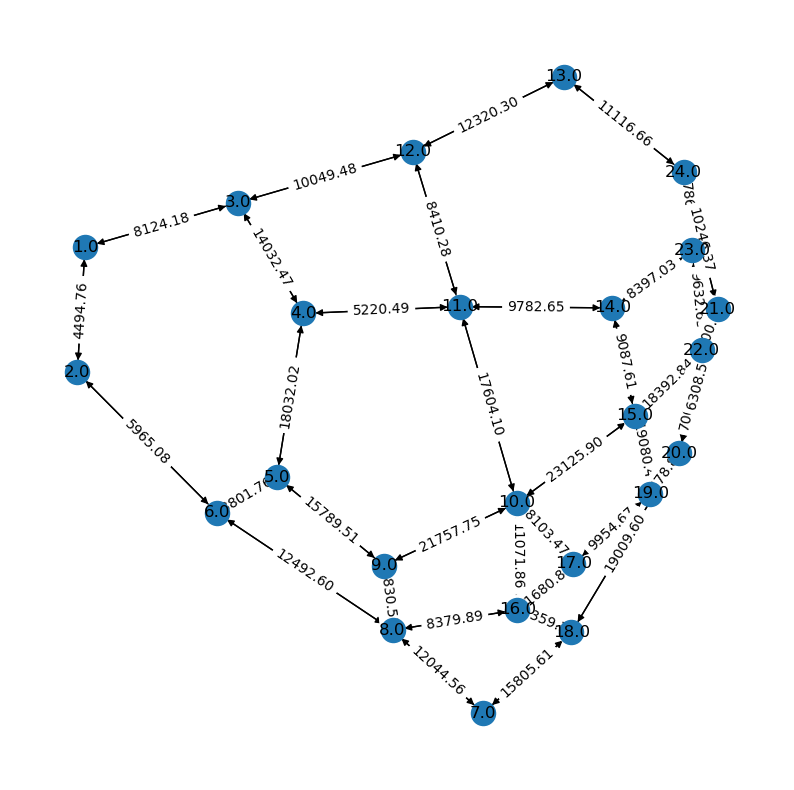

In [11]:
# Format the link_flow values to display with 2 digits
formatted_link_flow = [f'{flow:.2f}' for flow in model.link_flow]
print(formatted_link_flow)

# Create the plot
fig, ax = plt.subplots(figsize=(10,10))
G = model.get_graph()
pos = nx.spectral_layout(G)

# Draw the graph with labels
nx.draw(G, pos, with_labels=True)

# Add node labels
node_labels = nx.get_node_attributes(G, 'name')
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'travel_flow')

# Format edge labels to display with 2 digits
formatted_edge_labels = {edge: f'{flow:.2f}' for edge, flow in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels)

# Show the plot
plt.show()


In [6]:
# read the results

df_fw = pd.read_csv(f'results/{instance_name}/results_FW.csv', header=None, names=["iteration","gap","UE_cost"])
df_msa = pd.read_csv(f'results/{instance_name}/results_MSA.csv', header=None, names=["iteration","gap","UE_cost"])

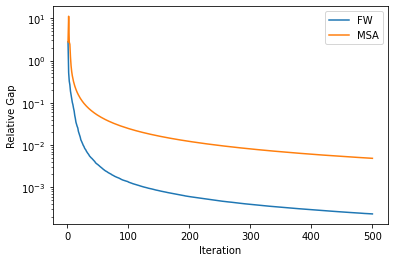

In [7]:
# plot the convergence curve
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(df_fw['iteration'],df_fw['gap'],label='FW')
ax.plot(df_msa['iteration'],df_msa['gap'],label='MSA')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Gap')
ax.legend()
plt.show()